## Supervised Regression- House Price Data

In [75]:
import numpy as np
import pandas as pd
import os

#Evalaluation
from sklearn import metrics
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline

# Grid
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

#Performance
%load_ext memory_profiler

#Warnings
#import warnings
#warnings.filterwarnings('ignore')

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [36]:
# Data
path= r"D:\My Computer\DATA\House Prices" #Windows
#path= r"/Users/nicapotato/Desktop/Data/House" #Mac

train_df = pd.read_csv(open(os.path.join(path, "house_train.csv"), "r"), index_col='Id')
test_df = pd.read_csv(open(os.path.join(path, "house_test.csv"), "r"), index_col='Id')

In [37]:
train_df['SalePrice']= np.log(train_df['SalePrice'])

In [38]:
#train_df.columns = test_df.columns

In [39]:
X = train_df.drop(["SalePrice"] , axis=1)
y = train_df["SalePrice"]

In [40]:
# use train/test split with different random_state values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1168, 254), (1168,), (292, 254), (292,))

In [41]:
test_df.shape

(1459, 254)

In [42]:
cv = 5

## Models

### Linear Regression

In [43]:
from sklearn import linear_model

In [44]:
model = linear_model.LinearRegression()

score = cross_val_score(model, X, y, cv=10)
print(score.mean())

0.837408858137


## XGBoost

In [69]:
?xgb.

In [49]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [63]:
# Human Analog Model
# https://www.kaggle.com/humananalog/xgboost-lasso/code
regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

regr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.2, gamma=0.0, learning_rate=0.01,
       max_delta_step=0, max_depth=4, min_child_weight=1.5, missing=None,
       n_estimators=7200, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.9, reg_lambda=0.6, scale_pos_weight=1,
       seed=42, silent=1, subsample=0.2)

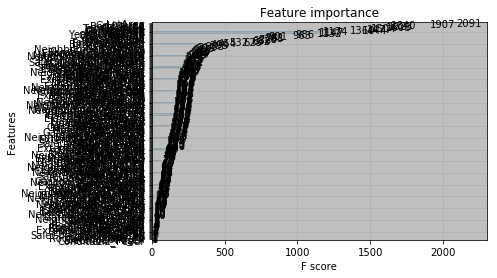

In [74]:
xgb.plot_importance(regr)

In [64]:
# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(X_train)
print("XGBoost score on training set: ", rmse(y_train, y_pred))

XGBoost score on training set:  0.0734687657636


In [62]:
y_pred = np.exp(pred_xgb)

pred_df = pd.DataFrame(y_pred, index=test_df.index, columns=["SalePrice"])
#pred_df.to_csv('output.csv', header=True, index_label='Id')
pred_df.to_csv((os.path.join(path, r"submission/output.csv")),header=True, index_label='Id')

### Nick's Optimized XGBoost

- General Parameters: Guide the overall functioning
- Booster Parameters: Guide the individual booster (tree/regression) at each step
- Learning Task Parameters: Guide the optimization performed



In [68]:
xgtrain = xgb.DMatrix(X_train, label=y_train)
xgtest = xgb.DMatrix(X_test, label=y_test)

In [77]:
np.arange(25,176,5)

array([ 25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,  85,
        90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150,
       155, 160, 165, 170, 175])

In [88]:
# set xgboost params
num_rounds = 100
param = {'colsample_bytree': 0.2,
                 'gamma':0.0,
                 'learning_rate':0.01,
                 'max_depth':4,
                 'min_child_weight':1.5,
                 'n_estimators':7200,                                                                  
                 'reg_alpha':0.9,
                 'reg_lambda':0.6,
                 'subsample':0.2,
                 'seed':42,
                 'silent':1}

regr_xgb_cv = xgb.cv(param, xgtrain, num_rounds, 
                    stratified=False, 
                    nfold=5, 
                    early_stopping_rounds=20)
print("Optimal number of trees/estimators is %i" % regr_xgb_cv.shape[0])

watchlist  = [(xgtest,'test'), (xgtrain,'train')]                
regr_xgb = xgb.train(param, xgtrain, regr_xgb_cv.shape[0], watchlist)

Optimal number of trees/estimators is 100
[0]	test-rmse:11.4546	train-rmse:11.4066
[1]	test-rmse:11.3412	train-rmse:11.2933
[2]	test-rmse:11.2288	train-rmse:11.1809
[3]	test-rmse:11.1175	train-rmse:11.0696
[4]	test-rmse:11.0075	train-rmse:10.9596
[5]	test-rmse:10.8983	train-rmse:10.8503
[6]	test-rmse:10.7906	train-rmse:10.7427
[7]	test-rmse:10.6835	train-rmse:10.6356
[8]	test-rmse:10.5781	train-rmse:10.5302
[9]	test-rmse:10.4738	train-rmse:10.4259
[10]	test-rmse:10.3695	train-rmse:10.3216
[11]	test-rmse:10.2666	train-rmse:10.2187
[12]	test-rmse:10.1649	train-rmse:10.1171
[13]	test-rmse:10.0645	train-rmse:10.0167
[14]	test-rmse:9.96481	train-rmse:9.91701
[15]	test-rmse:9.86608	train-rmse:9.81828
[16]	test-rmse:9.76824	train-rmse:9.72046
[17]	test-rmse:9.67141	train-rmse:9.62364
[18]	test-rmse:9.57548	train-rmse:9.52772
[19]	test-rmse:9.48039	train-rmse:9.43264
[20]	test-rmse:9.3867	train-rmse:9.33897
[21]	test-rmse:9.29382	train-rmse:9.2461
[22]	test-rmse:9.20152	train-rmse:9.15381
[23]

In [ ]:
y_pred = regr_xgb_cv.predict(X_train)
print("XGBoost score on training set: ", rmse(y_train, y_pred))

In [86]:
# predict function will produce the probability 
# so we'll use 0.5 cutoff to convert probability to class label
score= metrics.accuracy_score(y_test_pred, y_test)
print("XGB - Train : %.2f" % metrics.accuracy_score(y_train_pred, y_train))
print("XGB - Test : %.2f" % score)
#norm_save(model, "XGBstandard")

ValueError: Can't handle mix of binary and continuous

In [ ]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('train_modified.csv')
target = 'Disbursed'
IDcol = 'ID'

In [ ]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')